In [9]:
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import akshare as ak
from utils.utils import normalize, func_list
import warnings
warnings.filterwarnings('ignore')


In [13]:
FILE_PATH = '../data/raw/macro_data.xlsx'
START_DATE = '2016-01-01'
END_DATE = '2021-12-31'
EXPAND=365

In [14]:
def get_macro_data(file_path, start_date, end_date, expand=None):
    start_date, end_date = pd.to_datetime(start_date), pd.to_datetime(end_date)
    if expand:
        start_date = start_date - pd.Timedelta(expand, 'd')
    df = pd.read_excel(file_path)
    print(f'Features: {list(df.columns[1:])}')
    df.columns = ['date'] + [f'mf{i+1}' for i in range(df.shape[1] - 1)]
    df['date'] = pd.to_datetime(df['date'])

    df_trade_date = ak.tool_trade_date_hist_sina()
    trade_date_list = pd.to_datetime(df_trade_date['trade_date']).values
    df = df[df['date'].isin(trade_date_list)]
    df = df[(df['date'] >= start_date) & (df['date'] <= end_date)]
    df = df.sort_values(by='date').reset_index(drop=True)
    num_null = df.isnull().sum().sum()
    if num_null == 0:
        print('There is no NAs.')
    elif num_null > 0:
        print(f'There are {num_null} NAs.')
        print('Filling NAs with forward method.')
        df = df.fillna(method='ffill')
    
    return df

In [16]:
df_macro = get_macro_data(FILE_PATH, START_DATE, END_DATE, expand=EXPAND)
print('Unnormalized raw macro data.')
df_macro.head()

Features: ['中间价:美元兑人民币', 'SHIBOR:隔夜', 'SHIBOR:1年', '上证综合指数', '沪深300指数', '成交量:上证综合指数', '成交量:沪深300', '上证国债指数', '上证企债指数']
There is no NAs.
Unnormalized raw macro data.


,date,mf1,mf2,mf3,mf4,mf5,mf6,mf7,mf8,mf9
0,2015-01-05,6.1248,3.421,4.7429,3350.519,3641.541,531.352391,451.198098,145.798,181.281
1,2015-01-06,6.1256,3.032,4.7455,3351.446,3641.059,501.661695,420.962185,145.818,181.294
2,2015-01-07,6.1269,2.881,4.7476,3373.954,3643.790,391.918880,320.191232,145.837,181.303
3,2015-01-08,6.1302,2.830,4.7488,3293.456,3559.259,371.131170,295.003045,145.878,181.334
4,2015-01-09,6.1296,2.805,4.7490,3285.412,3546.723,410.240872,349.982672,146.028,181.341


In [17]:
def extend_macro_data(df, func_list=[]):
    '''
    construct features based on basic features
    include: pctchange + func_list
    drop raw absolute-valued features
    '''
    df = df.copy()
    features = df.drop(columns=['date']).columns
    for func in func_list:
        df_tmp = df_macro[features].transform(func)
        df_tmp.columns = [col + func.__name__ for col in features]
        df = pd.concat([df, df_tmp], axis=1)

    return df.drop(columns = features)

In [18]:
df_extended_macro = extend_macro_data(df_macro, func_list)
df_extended_macro = df_extended_macro[(df_extended_macro['date'] >= START_DATE) &
                                      (df_extended_macro['date'] <= END_DATE)]

df_extended_macro = df_extended_macro.reset_index(drop=True)
print('Unnormalized extended macro data.')
df_extended_macro.head()

Unnormalized extended macro data.


,date,mf1roc1,mf2roc1,mf3roc1,mf4roc1,mf5roc1,mf6roc1,mf7roc1,mf8roc1,mf9roc1,...,mf9std,mf1slope,mf2slope,mf3slope,mf4slope,mf5slope,mf6slope,mf7slope,mf8slope,mf9slope
0,2016-01-04,0.147838,0.200904,0.000000,-6.863846,-7.020589,4.212596,13.248893,0.077001,0.090303,...,0.496699,0.005016,0.011553,3.896104e-07,2.219418,4.653336,-0.454305,-0.075104,0.079961,0.081482
1,2016-01-05,0.210666,0.150376,0.000000,-0.259294,0.280003,44.715522,40.518364,0.024570,0.019261,...,0.505959,0.004753,0.012417,-0.000000e+00,-1.189949,0.808693,0.481168,0.390278,0.080575,0.083040
2,2016-01-06,0.222498,-0.900901,-0.089552,2.254730,1.754308,-10.489806,-9.962460,0.018099,0.030406,...,0.515173,0.004699,0.012730,-3.935065e-05,-3.157942,-1.842102,0.412911,0.098639,0.079616,0.084662
3,2016-01-07,0.508314,-0.707071,-0.029878,-7.044892,-6.933265,-70.459162,-69.785705,-0.010987,0.017225,...,0.516981,0.005036,0.012635,-8.779221e-05,-8.929473,-8.410950,-1.651512,-1.387598,0.077582,0.084983
4,2016-01-08,-0.015233,-0.406918,-0.029886,1.965119,2.039207,305.901065,321.651508,0.015513,0.067367,...,0.522517,0.005246,0.012245,-1.440260e-04,-13.421480,-13.495997,-1.122217,-1.103401,0.074838,0.085939


In [19]:
df_extended_macro.iloc[:, 1:] = df_extended_macro.iloc[:, 1:].apply(normalize)
print('Normalized extended macro data.')
df_extended_macro.head()

Normalized extended macro data.


,date,mf1roc1,mf2roc1,mf3roc1,mf4roc1,mf5roc1,mf6roc1,mf7roc1,mf8roc1,mf9roc1,...,mf9std,mf1slope,mf2slope,mf3slope,mf4slope,mf5slope,mf6slope,mf7slope,mf8slope,mf9slope
0,2016-01-04,0.707885,0.066139,-0.019809,-2.438289,-2.466979,0.210718,0.598259,2.068865,2.489524,...,1.932743,1.259285,0.695630,0.019559,0.277134,0.372384,-0.109252,-0.003270,2.307388,1.758241
1,2016-01-05,1.007368,0.057364,-0.019809,-0.308748,0.213792,2.559724,1.985194,0.338901,0.048802,...,2.012805,1.194519,0.745828,0.019502,-0.197838,-0.010536,0.128641,0.182446,2.333353,1.829576
2,2016-01-06,1.063772,-0.125210,-0.478377,2.330390,1.575289,-0.731736,-0.582279,0.125420,0.679315,...,2.092471,1.181169,0.764020,0.013713,-0.472006,-0.274551,0.111283,0.066064,2.292787,1.903824
3,2016-01-07,2.426181,-0.091548,-0.172802,-2.438289,-2.466979,-2.734669,-2.819907,-0.834284,-0.066381,...,2.108104,1.264311,0.758510,0.006588,-1.276061,-0.928799,-0.413705,-0.527037,2.206824,1.918507
4,2016-01-08,-0.069434,-0.039421,-0.172848,2.026366,1.838389,2.559724,2.583836,0.040071,2.489524,...,2.155969,1.315887,0.735864,-0.001685,-1.901860,-1.435262,-0.279104,-0.413625,2.090835,1.962260


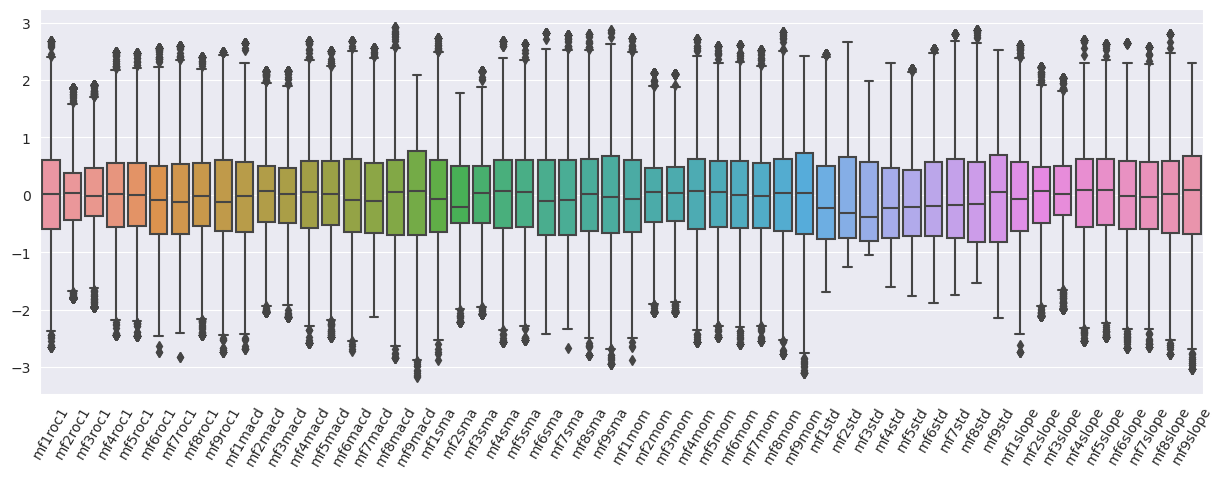

In [20]:
fig = plt.figure(figsize = (15, 5))
sns.boxplot(df_extended_macro)
plt.xticks(rotation=60)
plt.show()

In [21]:
# df_extended_macro.to_csv('../data/processed/macro_data.csv', index=False)